¡Vamos a encontrar el mejor lugar para abrir la sede de nuestra empresa!

En primer lugar, importo las librerías que necesito y un archivo propio de funciones. También la base de datos.

In [34]:
from pandas.io.json import json_normalize
import json
import src.apiFour as four
import src.geofun as fun
from cartoframes.viz.widgets import histogram_widget
from cartoframes.viz import size_continuous_style, color_bins_style, default_legend, popup_element
from pymongo import MongoClient
import pandas as pd
import geopandas as gpd
from cartoframes.viz import Map, Layer, Layout
client = MongoClient("mongodb://localhost/companies") 
db = client.get_database()

In [35]:
#Query en MongoDb
empresas1 = {"founded_year":{"$lte":2010}}
#Me traigo la info. en forma de lista
listaempresas1 = list(db["companies"].find(empresas1,{"_id":0,"name":1,"founded_year":1,"offices":1}))
#Creo un DataFrame con la info.
df_empresas1 = pd.DataFrame(listaempresas1)
#Saco la info de la columna "offices" que tiene dentro listas de diccionarios. Con explode se coloca la info
#en filas y se duplica el resto del registro.
df_empresas1 = df_empresas1.explode('offices')
#Creo un nuevo df con la info. de "offices" para aplicarle un "expand" al df (si no, lo haría sobre la serie)
dfOfficeData = df_empresas1[["offices"]].apply(lambda r: r.offices, result_type="expand", axis=1)
#Concateno ambos DataFrames
fin_empresas1 = pd.concat([df_empresas1,dfOfficeData], axis=1)
#Elimino la columna offices que no me quiero llevar a la nueva colección de MongoDB
fin_empresas1 = fin_empresas1.drop(columns=["offices"])
#Añado una nueva columna "location". Pasándole a las columnas latitud y longitud la función "asGeoJSON" 
#lo que obtenemos es un diccionario on el formato de MongoDB para guardar coordenadas y poder hacer indexes
fin_empresas1["location"] = fin_empresas1[["latitude","longitude"]].apply(lambda x:fun.asGeoJSON(x.latitude,x.longitude), axis=1)
#Exportamos el resultado como json para verlo en MongoDB Compass
fin_empresas1.to_json("output/empmasnue", orient="records")

Me llevo la info a una colección nueva en la BD de Mongo --> 
mongoimport --db companies --collection emp+9years --jsonArray emp+9years

Ya tengo una colección nueva con todas las empresas que tienen 9 años o más.
He leído que India es el país con más población vegana del mundo. También que Berlín es considerada la ciudad más Veggie por sus alternativas.
Voy a lanzar queries contra esa colección con el argumento $near para ver, de todas esas empresas, las que hay por Nueva Dheli.

In [36]:
#En NuevaDheli no hay ninguna empresa que cumpla características en nuestra BD. Así que deduzco que posiblemente no 
#haya un movimiento empresarial que nos interese....pruebo con Berlín.
nd = fun.geocode("Nueva Dheli")
q_nd = fun.withGeoQuery(nd)

In [37]:
#El resultado de esta GeoQuery me devuelve 20 empresas. 
#Voy a traerme los datos y a usar Carto para pintar dónde están.
ber = fun.geocode("Berlin")
q_ber = fun.withGeoQuery(ber)

In [38]:
GeoBerlin = {
  "location": {
    "$near": {
      "$geometry": {
        "type": 'Point',
        "coordinates": [
          13.40452,
          52.50135
        ]
      },
      "$maxDistance": 2000,
      "$minDistance": 0
    }
  }
}
mas9ber = list(db["emp+9years"].find(GeoBerlin))
df_mas9ber = pd.DataFrame(mas9ber)
berlin = fun.VisualizaCarto(df_mas9ber)
berlin["title"] = "Empresas + 9 años"
berlin["name"] = df_mas9ber["name"]
berlin = berlin.rename(columns={"name":"nameb"})

Como nos hemos planteado Berlín para poner nuestra sede, por ser considerada la ciudad más Veggie del mundo... vamos a ver dónde está el aeropuerto principal de Berlín y a ubicarlo en el mapa. 

In [39]:
#Vemos que el aeropuerto de Tegel está cerca del centro de la ciudad y lo marcamos con un punto azul.
aeropuerto = fun.geocode("Aeropuerto de Berlín-Tegel")
aero_coord = aeropuerto.get("coordinates")
tegel = fun.aDataF(aero_coord)

In [40]:
tegel["title"]= "Tegel"

In [41]:
Map([Layer(berlin, popup_hover=[
            popup_element('nameb', 'Emp. +9 años')]),
     Layer(tegel,'color:blue', popup_hover=[
            popup_element('title', 'Aeropuerto')
        ])
    ])

Voy a hacer una request a la API de Foursquare para encontrar restaurantes vegan en Berlín.

In [42]:
vegan = "4bf58dd8d48988d1d3941735" #código restaurantes veganos dentro de la documentación de foursquare
rest_vegan = four.requestFour(vegan,ber)

In [43]:
rest_df = pd.DataFrame(rest_vegan) #Lo convierto a df para ver cómo me saca los resultados
sitios = rest_df.iat[10,1] #Localizo la celda donde están los registros que me interesan.
veg = pd.DataFrame(sitios)
df_veg = veg.explode('items')

De todos los elementos que busque, los voy a guardar en dos formatos. Uno de ellos será GeoDataFrame para poder trabajar con Carto, y otro será con el "Point" que necesita MongoDB para hacer los index y lanzar las Geoqueries.

In [44]:
query_vegan = {"name":{"$eq":"recommended"}}
list_vegan = list(db["veganberlin"].find(query_vegan,{"_id":0,"items.venue.name":1,"items.venue.location.lat":1,"items.venue.location.lng":1}))
vegok = fun.GoodList(list_vegan)
df_vegan = pd.DataFrame(vegok)
dfloc = df_vegan[["location"]].apply(lambda r: r.location, result_type="expand", axis=1)
dfloc = dfloc[["lat","lng"]].rename(columns={"lat": "latitude", "lng":"longitude"})
dfloc['name']=df_vegan['name']

Creo la columna "Location" de todos los dataframes para sacar una lista de puntos geojson para lanzar queries para hacer el ranking. 

In [45]:
dfloc["location"] = dfloc[["latitude","longitude"]].apply(lambda x:fun.asGeoJSON(x.latitude,x.longitude), axis=1)

In [46]:
df_veg.to_json("output/veganberlin", orient="records") #Exporto los registros que me interesan a -json para verlos en MongoDB

Para visualizar los efectos Hover en Carto, añado una columna al DF con los nombres de los restaurantes.

In [47]:
vegan_map = fun.VisualizaCarto(dfloc)
vegan_map["namev"] = df_vegan["name"]

Voy a realizar los mismos pasos que con los restaurantes veganos pero con colegios. Los buscaré en la api de Foursquare, los llevo a MongoDB y después vuelvo a traerlos para pintarlos en el mapa final. Durante el proceso tengo que manipular los datos para que estén en el formato que necesito

In [48]:
#starbucks = "Starbucks"
#four.BuscayExporta(starbucks)

In [49]:
query_starbucks = {"items.venue.name":{"$eq":"Starbucks"}}
list_star = list(db["starbucksberlin"].find(query_vegan,{"_id":0,"items.venue.name":1,"items.venue.location.lat":1,"items.venue.location.lng":1}))
startok = fun.GoodList(list_star)
df_star = pd.DataFrame(startok)
dfstarbucks = df_star[["location"]].apply(lambda r: r.location, result_type="expand", axis=1)
dfstarbucks = dfstarbucks[["lat","lng"]].rename(columns={"lat": "latitude", "lng":"longitude"})
star_map = fun.VisualizaCarto(dfstarbucks)
star_map["titles"] = "Starbucks"

In [50]:
star_map["location"] = star_map[["latitude","longitude"]].apply(lambda x:fun.asGeoJSON(x.latitude,x.longitude), axis=1)

Voy a incluir en el mapa algunas salas de conciertos. He automatizado la búsqueda de Foursquare en una función. Y también hay una función para crear el Geodataframe a partir de la información de la query a la API de Foursquare

In [51]:
#fiesta = "party club"
#four.BuscayExporta(fiesta)

In [52]:
query_fiesta = {"name":{"$eq":"recommended"}}
list_fiesta = list(db["conciertos"].find(query_fiesta,{"_id":0,"items.venue.name":1,"items.venue.location.lat":1,"items.venue.location.lng":1}))
fiesta_ok = fun.GoodList(list_fiesta)
fiesta_map = fun.GeoDataframe(fiesta_ok)
fiesta_map = fiesta_map.rename(columns={"name": "namef"})

In [53]:
fiesta_map["location"] = fiesta_map[["latitude","longitude"]].apply(lambda x:fun.asGeoJSON(x.latitude,x.longitude), axis=1)

Busco también dónde hay colegios

In [54]:
colegios = "Schule"
four.BuscayExporta(colegios)
#mongoimport --db companies --collection colegios --jsonArray Schule

In [55]:
query_escuelas = {"name":{"$eq":"recommended"}}
list_escuelas = list(db["colegios"].find(query_escuelas,{"_id":0,"items.venue.name":1,"items.venue.location.lat":1,"items.venue.location.lng":1}))
escuelas_ok = fun.GoodList(list_escuelas)
escuelas_map = fun.GeoDataframe(escuelas_ok)
escuelas_map = escuelas_map.rename(columns={"name": "namee"})

In [56]:
escuelas_map["location"] = escuelas_map[["latitude","longitude"]].apply(lambda x:fun.asGeoJSON(x.latitude,x.longitude), axis=1)

In [57]:
Map([
    Layer(berlin, popup_hover=[
            popup_element('nameb', 'Emp. +9 años')
        ]),
    Layer(vegan_map, 'color:#44D32A',popup_hover=[
            popup_element('namev', 'Rest.Vegan')
        ]),
    Layer(star_map, 'color:#006241',popup_hover=[
            popup_element('titles', 'Starbucks')
        ]),
    Layer(fiesta_map, 'color:#7C2AD3',popup_hover=[
            popup_element('namef', 'Locales de fiesta')
        ]),
    Layer(escuelas_map, 'color:#98F3F1',popup_hover=[
            popup_element('namee', 'Escuelas')
        ]),
])

Como conecto con la ideología de la CEO de mi empresa, he decidido que pondremos la oficina encima de un restaurante vegano. Ahora vamos a hacer un ranking con el restaurante que tiene más elementos cerca de los que queremos.
Voy a ir lanzando geoqueries de los elementos que tengo contra la bd de MongoDB (con index) de restaurantes veganos.

In [77]:
#Aquí preparo el dataframe donde voy a ir construyendo el ranking
vegan_ranking = vegan_map.drop(columns = ["latitude", "longitude","name","geometry"])

In [78]:
#Primero preparo las listas con la localización.
star_list = [i for i in star_map["location"]]
escuelas_list = [i for i in escuelas_map ["location"]]
fiesta_list = [i for i in fiesta_map["location"]]
empresas_list = [i for i in berlin["location"]]
vegan_list = [i for i in vegan_ranking["location"]]

Starbucks

In [79]:
starbucksdb = db.starbien
radio_meters = 500
stars = fun.QueryRanking(star_list, vegan_list,radio_meters,starbucksdb)
vegan_ranking['Starbucks500m'] = stars

Lugares de fiesta

In [91]:
fiestadb = db.fiestabien
radio_meters = 2000
fiestas = fun.QueryRanking(fiesta_list, vegan_list,radio_meters, fiestadb)
vegan_ranking['Fiesta2km'] = fiestas

Escuelas 

In [92]:
escuelasdb = db.escuelasbien
radio_meters = 4000
escuelas = fun.QueryRanking(escuelas_list, vegan_list,radio_meters, escuelasdb)
vegan_ranking['Escuelas4km'] = escuelas

In [93]:
escuelas_map["location"] = escuelas_map[["latitude","longitude"]].apply(lambda x:fun.asGeoJSON(x.latitude,x.longitude), axis=1)

Empresas de más de 9 años penalizarán. Nos alejaremos de ellas.

In [94]:
empdb = db.empmasnueve
radio_meters = 1000
empresas = fun.QueryRanking(empresas_list, vegan_list,radio_meters, empdb)
vegan_ranking['Empresas+9'] = empresas

In [95]:
vegan_ranking["puntuación"] = (vegan_ranking["Starbucks500m"] *0.2) + (vegan_ranking["Fiesta2km"] *0.4) + (vegan_ranking["Escuelas4km"] *0.4) + (vegan_ranking["Empresas+9"] * (-0.1))

In [108]:
vegan_ranking.sort_values("puntuación", ascending=False)

,location,namev,Starbucks500m,Fiesta2km,Escuelas4km,Empresas+9,puntuación
4,"{'type': 'Point', 'coordinates': [13.437730319...",Volkskammer - Das DDR Design Restaurant,1,11,7,1,7.3
0,"{'type': 'Point', 'coordinates': [13.428211044...",D'Espresso,0,12,5,4,6.4
6,"{'type': 'Point', 'coordinates': [13.453954, 5...",La Tazza d'Oro,0,11,5,1,6.3
21,"{'type': 'Point', 'coordinates': [13.454978, 5...",D. Machts Style Friedrichshain - Evelin Moos,0,11,4,1,5.9
10,"{'type': 'Point', 'coordinates': [13.4092512, ...",Schadow Tech Freunde-Code: MICDE8DV,3,6,9,10,5.6
1,"{'type': 'Point', 'coordinates': [13.402238558...",DDR Museum,1,6,9,12,5.0
13,"{'type': 'Point', 'coordinates': [13.45833, 52...",Le Coq d'Or,0,9,4,2,5.0
12,"{'type': 'Point', 'coordinates': [13.407636993...",DDR Motorrad-Museum,3,5,9,12,5.0
7,"{'type': 'Point', 'coordinates': [13.40301388,...",3DyourBody,0,6,8,7,4.9
8,"{'type': 'Point', 'coordinates': [13.378545935...",Denkmal für die ermordeten Juden Europas,2,1,7,5,3.1


Montaremos la sede de nuestra empresa encima del "Volkskammer - Das DDR Design Restaurant" (que tiene la puntuación más alta) en el barrio de FRIEDRICHSTAIN. 
Al ver el mapa, podíamos intuir que esa era la zona que íbamos a escoger. Y al calcular el ranking vemos que estábamos en lo cierto. 

In [104]:
localizacion = vegan_ranking.loc [vegan_ranking["namev"]== "Volkskammer - Das DDR Design Restaurant"]["location"]

In [119]:
vegan_ranking.iloc[4]["location"]["coordinates"]

[13.4377303197, 52.5112402979]

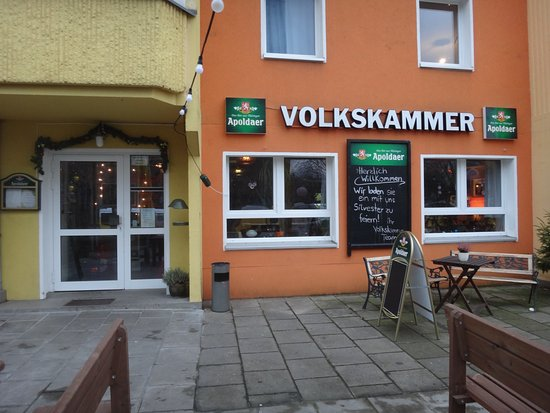

In [120]:
from IPython.display import Image
Image(filename='output/caption.jpg')